# **Financial Derivatives Pricing & Risk Analysis**

### Project Overview
This project demonstrates a full workflow that mirrors the responsibilities of a quantitative analyst or risk manager. This includes:
1.	Collect real market data for a publicly traded stock (Apple Inc., AAPL).
2.	Model the price behavior using historical and conditional volatility (GARCH).
3.	Price derivatives (European call options) using Black-Scholes, and calculate sensitivities (Greeks).
4.	Construct a portfolio combining the stock and options.
5.	Measure and simulate portfolio risk using parametric and Monte Carlo Value at Risk (VaR).
6.	Visualize results and interpret findings for practical decision-making.

**Objective**: Simulate the value at risk involved in options trading for a stock portfolio.

In [1]:
# Import necessary libraries
import yfinance as yf
import pandas_datareader.data as web
from arch import arch_model

import pandas as pd
import numpy as np

from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams.update({'figure.dpi': 150})

from scipy.stats import norm
import seaborn as sns

#### Step 1: Choose a Stock and Download Market Data

In [2]:
# Choose a stock
ticker = "AAPL" # (Apple Inc.)

In [3]:
# Download last 1 year of daily prices (from Jan 1, 2020 to Jan 1, 2025)
data = yf.download(ticker, start="2020-01-01", end="2025-01-01", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [4]:
data.columns = data.columns.get_level_values(0)
data

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,72.538506,72.598884,71.292296,71.545882,135480400
2020-01-03,71.833275,72.594040,71.608669,71.765651,146322800
2020-01-06,72.405678,72.444321,70.703012,70.954188,118387200
2020-01-07,72.065140,72.671333,71.845362,72.415330,108872000
2020-01-08,73.224419,73.526310,71.768094,71.768094,132079200
...,...,...,...,...,...
2024-12-24,257.286682,257.296626,254.386957,254.586262,23234700
2024-12-26,258.103729,259.179926,256.718662,257.276679,27237100
2024-12-27,254.685867,257.784882,252.164818,256.917934,42355300


In [5]:
data.isna().sum()

Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

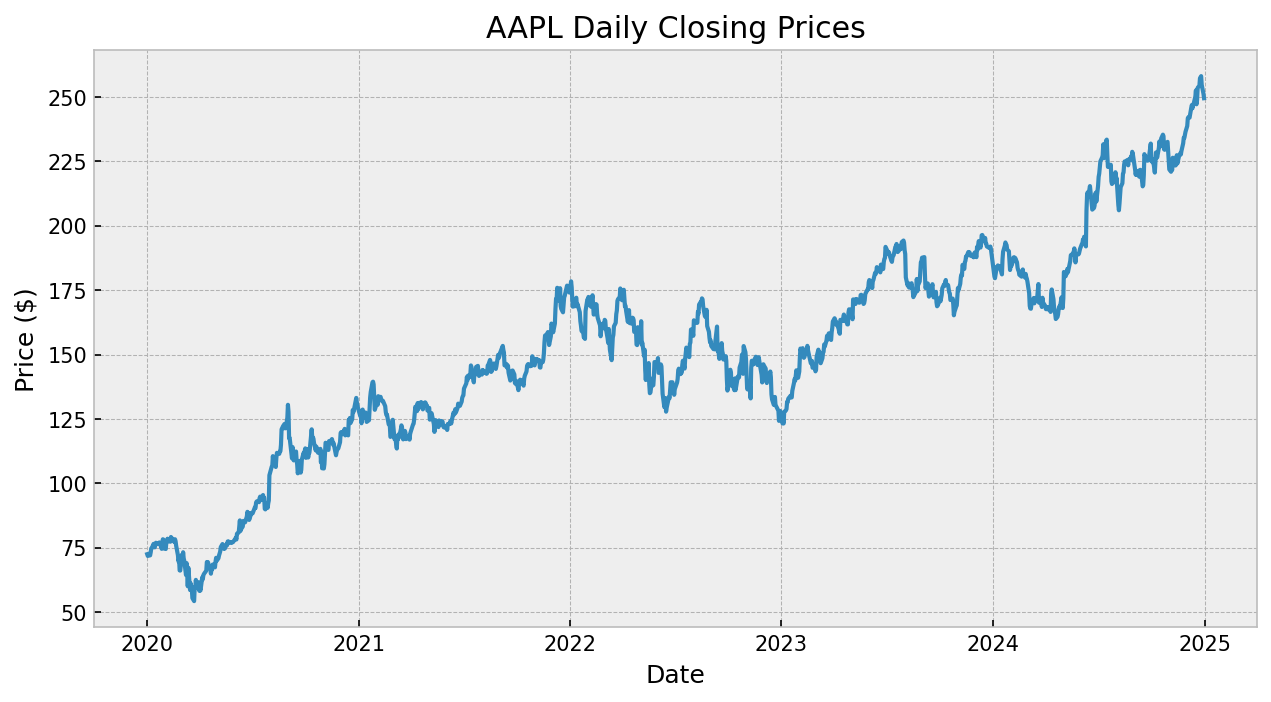

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Close'])
plt.title(f"{ticker} Daily Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.show()

#### Step 2: Calculate Daily Returns

In [7]:
data['Returns'] = data['Close'].pct_change()

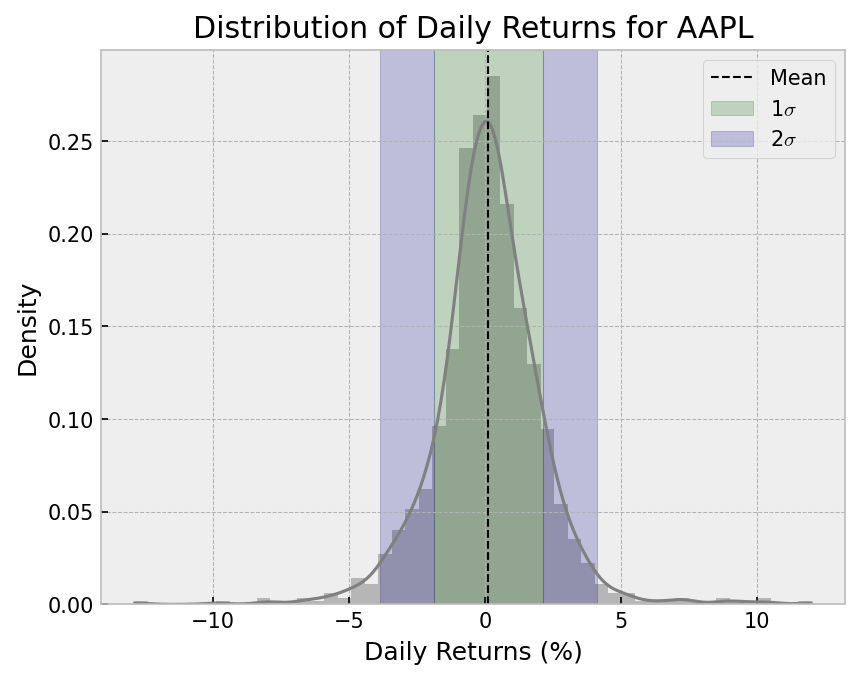

In [8]:
sns.histplot(data['Returns'].dropna() * 100, bins=50, kde=True, stat="density", alpha=0.5, color='grey', edgecolor=None, line_kws={'linewidth': 1.5})

# Highlight the mean and standard deviations
mean_return = data['Returns'].mean() * 100
std_return = data['Returns'].std() * 100

plt.axvline(mean_return, linestyle='--', lw=1, color='black', label='Mean')

# Shade areas for standard deviations
plt.axvspan(xmin=mean_return - std_return, xmax=mean_return + std_return, color='darkgreen', alpha=0.2, label=r'1$\sigma$')
plt.axvspan(xmin=mean_return - 2*std_return, xmax=mean_return - std_return, color='darkblue', alpha=0.2, label=r'2$\sigma$')
plt.axvspan(xmin=mean_return + std_return, xmax=mean_return + 2*std_return, color='darkblue', alpha=0.2)

plt.legend()
plt.xlabel('Daily Returns (%)')
plt.ylabel('Density')
plt.title(f'Distribution of Daily Returns for {ticker}')
plt.show()

#### Step 3: Calculate Volatility

##### 3a: Historical Volatility
It is a standard deviation of returns, showing how "noisy" or "risky" the asset is. 

In [9]:
# Calculate annualized volatility
daily_vol = data['Returns'].std()
trading_days = 252  # Typical number of trading days in a year
annual_vol = daily_vol * np.sqrt(trading_days) 

print(f"\nAnnualized Volatility: {annual_vol*100:.2f}%")


Annualized Volatility: 31.68%


This shows that Apple's stock fluctuates ~31.7% per year on average

##### 3b: GARCH Volatility Modeling

Real markets exhibit volatility clustering (calm perdios vs. high-stress periods). Hence, we use statistical models to model how volatility changes over time. We compare historical constant volatility with conditional volatility from GARCH.

Notes about ARCH:

* ARCH stands for Autoregressive Conditional Heteroskedasticity
	* *Autoregressive* → depends on past values.
	* *Conditional* → today’s volatility depends on what happened yesterday.
	* *Heteroskedasticity* → variance (volatility) is not constant; it changes.

* This model says, "If yesterday's return was big (up or down), then today's volatility is likely to be high."

* Mathematically, $\sigma_t^2 = \omega + \alpha \cdot \epsilon^2_{t-1}$
    where, 
    - $\sigma_t^2$ = today's variance (volatility squared)
    - $\epsilon^2_{t-1}$ = yesterday's squared return (big return $\rightarrow$ big volatility)
    - $\omega$, $\alpha$ = constants estimated from data (model fitting)
* ARCH(1) means it looks back one day
While this model is useful, this only looks at the last day's return. That can be too simplistic since volatility tends to 'persist' for a while.


Notes about GARCH:
* GARCH stands for Generalized ARCH (Adds a term for past volatility itself)
* Mathematically, $\sigma_t^2 = \omega + \alpha \cdot \epsilon^2_{t-1} + \beta \cdot \sigma^2_{t-1}$
* This model says that today's volatility depends on two factors: 1. how big yesterday's shock was (ARCH part), and 2. how high volatility was yesterday (GARCH part)
* Can smoothly describe how volatility clusters


##### _Intuitive explanation_

Let’s say you’re watching daily stock returns.
* If yesterday had a big move (e.g. +5% or −5%), today the market feels uncertain → volatility goes up.
→ That’s the ARCH(1) effect (reacting to last shock).
* If volatility was already high yesterday, even if today’s move wasn’t huge, the market tends to “stay nervous.”
→ That’s the GARCH(1) effect (volatility persistence).

So, GARCH(1,1) mixes both effects:

“Volatility today = constant base + reaction to yesterday’s surprise + continuation of yesterday’s volatility.”

In [10]:
returns = data['Returns'].dropna() 
garch = arch_model(returns, vol='Garch', p=1, q=1)
res = garch.fit(disp='off')
forecast = res.forecast(horizon=1)
sigma_daily = np.sqrt(forecast.variance.values[-1,0]) # Forecasted volatility for next day
sigma_annual = sigma_daily * np.sqrt(trading_days)

In [11]:
print("*------------------*")
print(" One day volatility")
print("*------------------*")
print(f"Historical: {daily_vol*100:.2f}%")
print(f"GARCH: {sigma_daily*100:.2f}%")

print("\n\n*------------------*")
print("Annualized volatility")
print("*------------------*")
print(f"Historical: {annual_vol*100:.2f}%")
print(f"GARCH: {sigma_annual*100:.2f}%")


*------------------*
 One day volatility
*------------------*
Historical: 2.00%
GARCH: 1.29%


*------------------*
Annualized volatility
*------------------*
Historical: 31.68%
GARCH: 20.46%


In [12]:
res.params

mu          0.001664
omega       0.000008
alpha[1]    0.100000
beta[1]     0.880000
Name: params, dtype: float64

Note that $\alpha + \beta = 0.98 < 1$, which is a **necessary condition for stationarity and mean-reversion** in volataility. Essentially, this means that volatility shocks decay slowly (because very close to one) but eventually fade.

##### Volatility half-life

In [13]:
alpha = res.params['alpha[1]']
beta = res.params['beta[1]']
half_life = np.log(0.5) / np.log(alpha + beta)
print(f"Volatility Half-life: {half_life:.2f} days")

Volatility Half-life: 34.31 days


This means that after ~34 days, a volatility shock is half as strong as initially.

In [14]:
sigma_series = res.conditional_volatility

In [15]:
data['GARCH_Volatility'] = sigma_series
data['Annualized_GARCH_Volatility'] = sigma_series * np.sqrt(trading_days)

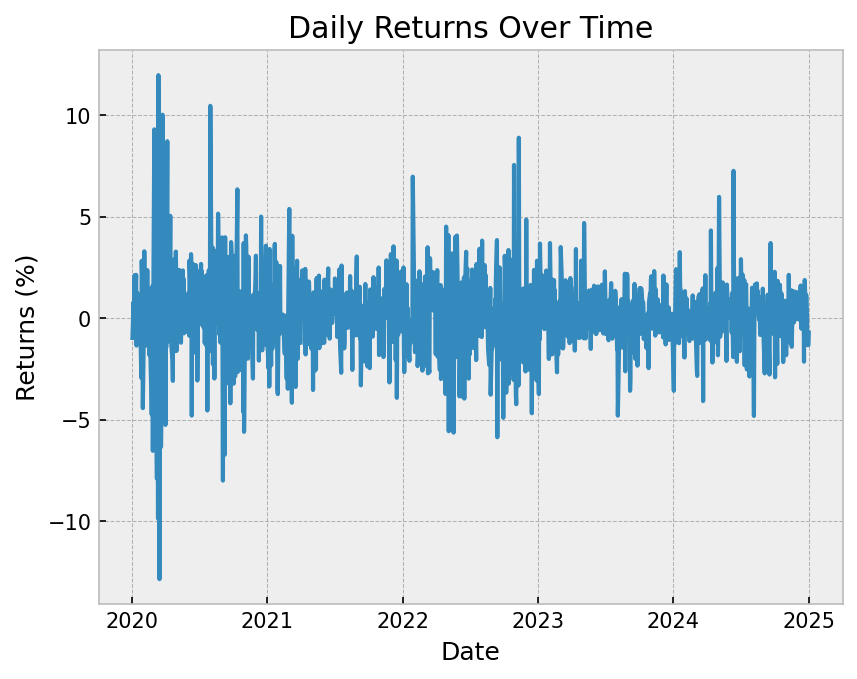

In [16]:
plt.plot(returns.index, returns * 100, label='Daily Returns')
plt.xlabel("Date")
plt.ylabel("Returns (%)")
plt.title("Daily Returns Over Time")
plt.show()

#### Step 4: Black-Scholes Option Pricing

Now we move into derivatives, specifically options. An **option** gives you the right but not the obligation to buy/sell an asset in the future at a fixed price (the strike price, K).

Types
* Call option → right to buy at K
* Put option → right to sell at K

We’ll price a European call option, which can only be exercised at expiry (not before).

The Black-Scholes formula for a European call option is:

$C = S_0 \cdot N(d_1) - K e^{-rT} \cdot N(d_2)$

Where:
* C → Call option price
* last_price → current stock price
* K → strike price
* T → time to expiry/maturity in years
* r → risk-free interest rate
* σ → volatility of the stock
* N() → cumulative normal distribution

Here, 
$ d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma \sqrt{T}}, \quad d_2 = d_1 - \sigma \sqrt{T}$
* $d_1$:  “moneyness” adjusted for risk and time — how far current price is from strike in standard deviation units.
* $d_2$: same, but excludes half the variance drift.

In [17]:
def black_scholes_call(S, K, T, r, sigma):
    sqrt_T = np.maximum(np.sqrt(T), 1e-12) # Prevent division by zero
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt_T)
    d2 = d1 - sigma * sqrt_T
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

To get risk-free interest rate, we fetch data from Federal Reserve Economic Data (FRED) website, run by U.S. central bank. Some pointers to note:
* `DGS1MO` is the 1-month U.S. Treasury Constant Maturity Rate
* U.S. Treasury - The U.S. government borrows money by selling 'Treasury securities' (like bonds)
* Constant Maturity Rate - standardized interest rate the government publishes every day. It’s like saying, “If we borrowed money for 1 month today, this would be the interest rate.”

**Why we use this?**
This rate is often treated as the risk-free interest rate because lending to the U.S. government for 1 month is considered almost zero risk (they always pay back).
That’s why in finance and investing, people use `DGS1MO` (or other Treasury rates like 3-month, 1-year, etc.) as a baseline to compare other investments.

Hence, if a stock gives you 7% return per year, and the risk-free rate is 5%, you can say that you earned extra reward of 2% for taking risk.

Note: One could also use `DGS3MO`, `DGS6MO`, `DGS1`, etc. but here, we shall assume that the option expiry is 30 days and therefore use `DGS1MO`.

In [18]:
rf = web.DataReader('DGS1MO', 'fred', '2024-01-01', '2025-01-01')  # 1-month Treasury rate
rf

,DGS1MO
DATE,
2024-01-01,NaN
2024-01-02,5.55
2024-01-03,5.54
2024-01-04,5.56
2024-01-05,5.54
...,...
2024-12-26,4.45
2024-12-27,4.44
2024-12-30,4.43


In [19]:
rf_ffill = rf.fillna(method='ffill')  # forward fill missing values (to account from weekends/holidays)
r = rf_ffill.iloc[-1].values[0] / 100  # latest rate as decimal

In [20]:
# For example, taking the last closing price as last_price
days_to_expiry = 30  # days until option expiry
K = 250  # strike price

last_price = data['Close'].iloc[-1]  # latest price
T = days_to_expiry/trading_days  # 30 days to expiry

call_price = black_scholes_call(last_price, K, T, r, sigma_annual)
print(f"European Call Option Price: ${call_price:.2f}")

European Call Option Price: $7.44


This means that a 1-month call option with strike $250 costs $7.44.

**How to use this information?**
1.	Compare to market price:
    * If market call price > Black-Scholes price → option may be “expensive”
    * If market call price < Black-Scholes price → option may be “cheap”

2.	Estimate risk-adjusted hedging:
    * Use it to determine how many shares to buy/sell to hedge an option (delta-hedging).

3.	Feed into trading strategies:
    * You can combine Black-Scholes price with volatility forecast to make trading decisions.

In [21]:
# Suppose data.index is datetime
expiry_date = data.index[-1] + timedelta(days=days_to_expiry)

# For each date, compute time-to-expiry
data['T'] = (expiry_date - data.index).days / trading_days

# Compute option price for each day
data['Call_Price'] = black_scholes_call(
    S=data['Close'],
    K=K,
    T=data['T'],
    r=r,
    sigma=sigma_annual
)

#### Step 5: The Greeks - Sensitivities

Greeks are derivatives of the option price with respect to key inputs.

Think of Greeks as risk measures:
1.	Delta (Δ) – How much the option price changes if the stock price moves by $1.
	* Measures sensitivity to Stock Price (S)
	* Call option: 0 → 1
	* Put option: -1 → 0
	* Intuition: If Δ = 0.6, a $1 increase in stock → $0.60 increase in call price.
2.	Gamma (Γ) – How much delta changes if the stock price moves by $1.
	* Measures curvature of the option price.
	* Measures sensitivity to Delta $\Delta$
	* High gamma → option price reacts sharply to stock moves.
3.	Theta (Θ) – How much the option price decreases per day due to time decay.
	* Measures sensitivity to Time
	* Options lose value as expiry approaches.
4.	Vega (ν) – How much the option price changes if volatility changes by 1%.
	* Measures sensitivity to Volatility ($\sigma$)
	* Higher volatility → more expensive options.
5.	Rho (ρ) – How much the option price changes if risk-free interest rate $r$ changes by 1%.
	* Measures sensitivity to Interest Rate ($r$)

For European call options, the formulas are:

$\Delta = N(d_1)$

$\Gamma = \frac{N’(d_1)}{S \sigma \sqrt{T}}$

$\Theta = -\frac{S N’(d_1) \sigma}{2\sqrt{T}} - r K e^{-rT} N(d_2)$

Vega = $S \sqrt{T} N’(d_1)$

Rho = $K T e^{-rT} N(d_2)$

Where $N’(d1)$ is the standard normal PDF.

In [22]:
def greeks_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    delta = norm.cdf(d1)
    
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
             - r * K * np.exp(-r*T) * norm.cdf(d2)) 
    theta_per_day = theta / trading_days  # per day
    
    vega = S * np.sqrt(T) * norm.pdf(d1) 
    vega_per_1pct = vega / 100  # per 1% change
    
    rho = K * T * np.exp(-r*T) * norm.cdf(d2) 
    rho_per_1pct = rho / 100  # per 1% change

    return delta, gamma, theta, theta_per_day, vega, vega_per_1pct, rho, rho_per_1pct

In [23]:
delta, gamma, theta, theta_per_day, vega, vega_per_1pct, rho, rho_per_1pct = greeks_call(last_price, K, T, r, sigma_annual)

print(f"Delta: {delta:.3f}", \
      f"\nGamma: {gamma:.4f}", \
      f"\nTheta: {theta:.3f}", \
      f"\nTheta per day: {theta_per_day:.3f}", \
      f"\nVega: {vega:.3f}", \
      f"\nVega per 1%: {vega_per_1pct:.3f}", \
      f"\nRho: {rho:.3f}", \
      f"\nRho per 1%: {rho_per_1pct:.3f}"
      )

Delta: 0.533 
Gamma: 0.0226 
Theta: -34.939 
Theta per day: -0.139 
Vega: 34.230 
Vega per 1%: 0.342 
Rho: 14.951 
Rho per 1%: 0.150


* Delta = 0.533 → Means the option price changes by $0.533 for every $1 move in the stock price. It shows roughly that there is 53% probability of finishing *in-the-money* at expiration.
* Gamma ≈ 0.0226 → For each $1 increase in stock, delta will increase by 0.0226
* Theta negative → loses value each day as time passes. The option loses about $0.14 per day due to time decay, assuming other factors constant. Negative theta = bad for buyers, good for sellers.
* Vega ≈ 0.342 → For each 1% increase in implied volatility, option price rises $0.342.
* Rho = 0.15 → For each 1% increase in the risk-free rate, option value rises $0.15. Interest rate effects are small for short-term options, and more relevant for long-dated ones.

#### Step 6: Portfolio Setup

We setup up a portfolio combining shares and call option.

In [24]:
shares = 100
contract_size = 100  # standard contract size
option_units = 10 * contract_size  

option_price_today = black_scholes_call(last_price, K, T, r, sigma_annual)

portfolio_value = shares * last_price + option_units * option_price_today
print(f"Portfolio Value: ${portfolio_value:.2f}")

Portfolio Value: $32395.55


#### Step 7: Risk Measurement (VaR)

Tells "How much can I lose in a day, with 95% confidence?"

Think of VaR as a “worst-case loss” indicator:
* Example: “Our 1-day 5% VaR is $1,000.”
* This means there’s a 5% chance that the portfolio will lose more than $1,000 in one day.

There are three main methods to calculate VaR:
1.	Historical Simulation – Use past returns of assets.
2.	Variance-Covariance (Parametric) – Assume returns are normally distributed.
3.	Monte Carlo Simulation – Simulate thousands of possible future outcomes.

In [25]:
# Daily portfolio value
data['Portfolio_Value'] = shares * data['Close'] + option_units * data['Call_Price']

# Daily portfolio return 
data['Portfolio_Returns'] = data['Portfolio_Value'].pct_change()

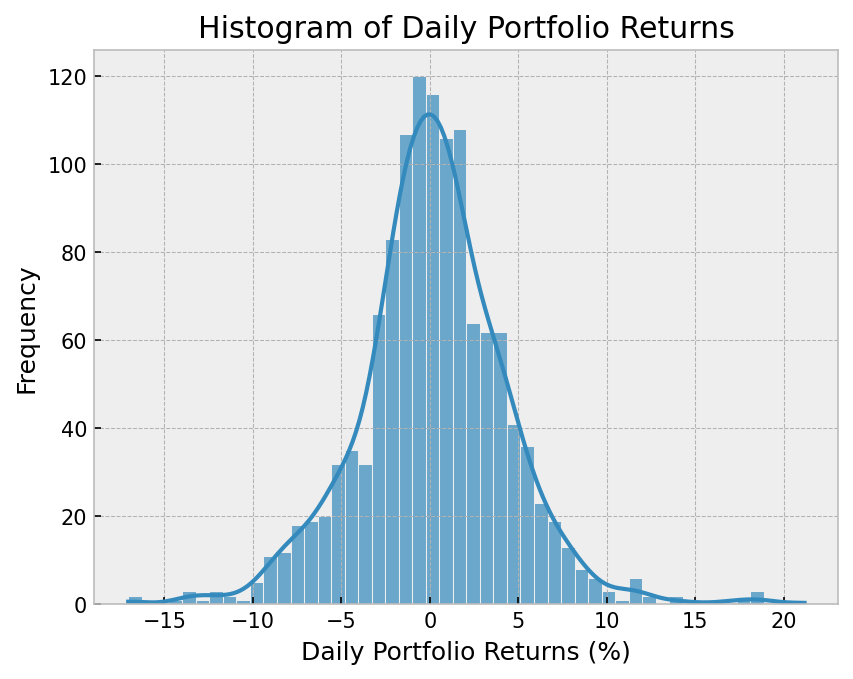

In [26]:
sns.histplot(data['Portfolio_Returns'].dropna() * 100, bins=50, alpha=0.7, kde=True)
plt.xlabel("Daily Portfolio Returns (%)")
plt.ylabel("Frequency")
plt.title("Histogram of Daily Portfolio Returns")
plt.show()

Note that this is a linear approximation, but it works well enough for small moves. We also see a very rough bell-shaped curve, signifying that we can use parametric VaR to **approximate** risk

##### 7a: 1-Day VaR (Parametric)

Assuming normal distribution of returns:

$\text{VaR} = z_\alpha \cdot \sigma_p \cdot \text{Portfolio Value}$
* $z_\alpha$ = critical value from standard normal (e.g., 1.65 for 5%, in other words z-score for 5th percentile)
* $\sigma_p$ = standard deviation of portfolio returns

In [27]:
confidence_level = 0.05
z = -norm.ppf(confidence_level)

# Portfolio standard deviation
sigma_p = data['Portfolio_Returns'].std()

VaR_1day = z * sigma_p * portfolio_value
print(f"1-Day 5% VaR: ${VaR_1day:.2f}")

1-Day 5% VaR: $2244.70


Interpretation: There’s a 5% chance your portfolio could lose more than this amount tomorrow.

##### 7b: Monte Carlo Simulation for VaR

Idea:
We simulate thousands of possible future stock prices, recalculate the option price using Black-Scholes, then compute the portfolio value for each simulation. Finally, we use the distribution of portfolio changes to estimate VaR.

##### Simulate Future Stock Prices

The most common model used to describe stock prices and other financial assets is **Geometric Brownian Motion** (GBM). It is a stochastic process described by 

$ dS_t = \mu S_t dt + \sigma S_t dW_t$
Where:
* $S_t$ = stock price at time $t$
* $\mu$ = drift (average daily return)
* $\sigma$ = (daily) volatility (standard deviation of returns)
* $dW_t$ = a Wiener process increment (random shock, standard normal)

Intuitively, the first term (drift term) models the expected trend of the stock while the second term (diffusion term) adds random fluctuations, proportional to the stock price.

Under the assumption that the stock returns are normally distributed, we discretize the above formalism over a small time step $\Delta t$:


$S_{t+1} = S_t \cdot \mathrm{exp} ({( \mu - 0.5 \sigma^2 ) \Delta t + \sigma \sqrt{\Delta t} \cdot Z})$

Where:
* $Z \sim N(0,1)$ is a standard normal random variable 
* $( \mu - 0.5 \sigma^2 ) \Delta t \rightarrow$ adjusts drift to account for volatility in log-space
* $\sigma \sqrt{\Delta t} \cdot Z \rightarrow$ random shock scaled by volatility and timestep

In [28]:
num_simulations = 100_000
dt = 1 # Simulate for 1-day-ahead

# Parameters for simulation
mu_daily = data['Returns'].dropna().mean()

In [29]:
# Simulate 1-day ahead prices
np.random.seed(42)
Z = np.random.normal(0, 1, num_simulations)
S_future = last_price * np.exp((mu_daily - 0.5 * sigma_daily**2) * dt + sigma_daily * np.sqrt(dt) * Z)

##### Recalculate Option Prices for Each Simulation

We recalculate European call option price for 1-day forward using Black-Scholes.

In [30]:
# Reprice option with annual volatility and time in years
T_1day = days_to_expiry / trading_days  # 1 day to expiry
option_prices_future = black_scholes_call(S_future, K, T_1day, r, sigma_annual)

##### Calculate Portfolio Value Changes

In [31]:
portfolio_future = shares * S_future + option_units * option_prices_future
portfolio_change = portfolio_future - portfolio_value

##### Estimate 1-Day Monte Carlo VaR

Take the 5th percentile of simulated losses:

In [32]:
alpha = 0.05 # 5% VaR
losses = -(portfolio_future - portfolio_value)

VaR_mc = np.percentile(losses, (1-alpha) * 100)  # because large loss = right tail
ES_mc = losses[losses >= VaR_mc].mean()

print(f"1-Day {int(alpha*100)}% Monte Carlo VaR: ${VaR_mc:.2f}")
print(f"1-Day {int(alpha*100)}% Expected Shortfall: ${ES_mc:.2f}")

1-Day 5% Monte Carlo VaR: $2861.03
1-Day 5% Expected Shortfall: $3513.87


##### Visualize the distribution

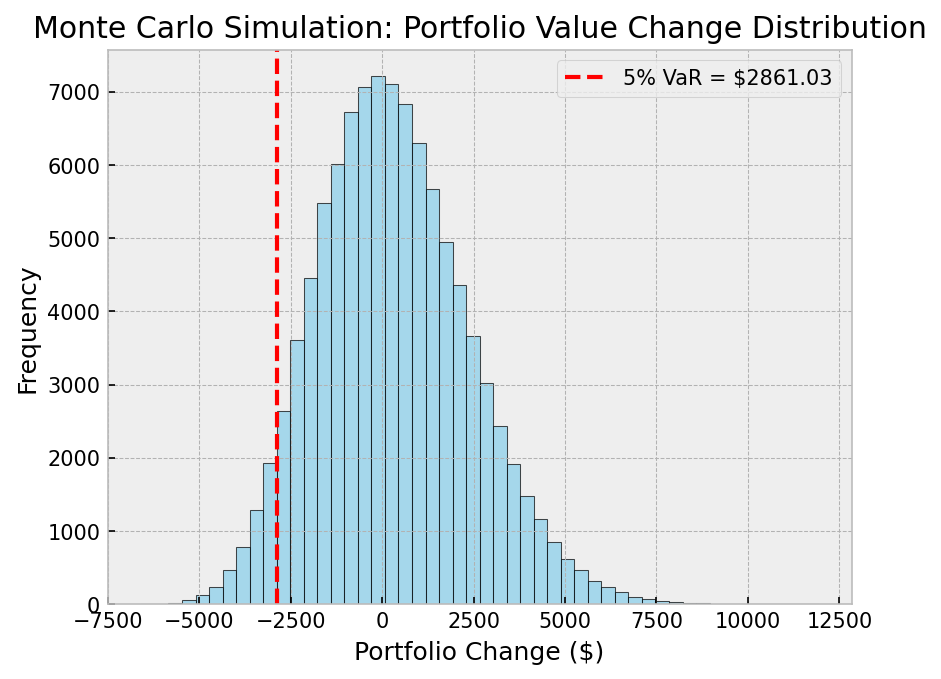

In [33]:
plt.hist(portfolio_change, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(-VaR_mc, color='red', linestyle='--', label=f'5% VaR = ${VaR_mc:.2f}')
plt.title("Monte Carlo Simulation: Portfolio Value Change Distribution")
plt.xlabel("Portfolio Change ($)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Implementing Monte Carlo using a function for better reproducibility

In [34]:
# --- Monte Carlo VaR function ---
def monte_carlo_var(
    last_price,
    shares,
    option_units,
    last_option_price,
    K,
    days_to_expiry,
    r,
    sigma_annual,     
    mu_annual,        
    h=1,              # VaR horizon in trading days
    n_sims=20000,
    trading_days=252,
    alpha=0.01,       
    seed=42
):
    np.random.seed(seed)

    # Convert to daily parameters
    sigma_daily = sigma_annual / np.sqrt(trading_days)
    mu_daily = mu_annual / trading_days

    # Time to expiry in years
    T0 = days_to_expiry / trading_days
    T_after = max((days_to_expiry - h) / trading_days, 0.0)  # in years
    
    # Simulate stock price at horizon (ST) using Geometric Brownian Motion (GBM)
    z = np.random.normal(size=n_sims)
    ST = last_price * np.exp((mu_daily - 0.5 * sigma_daily**2) * h + sigma_daily * np.sqrt(h) * z)

    # Reprice option at horizon using remaining time to expiry (T_after)
    call_T0 = last_option_price
    call_T_after = black_scholes_call(ST, K, T_after, r, sigma_annual)  # sigma here is annualized

    # Portfolio mark-to-market values
    PV_t0 = shares * last_price + option_units * call_T0
    PV_t1 = shares * ST + option_units * call_T_after

    pnl = (PV_t1 - PV_t0)  # absolute P&L
    ret = pnl / PV_t0      # fractional returns
    losses = -pnl # positive = loss

    # VaR (1% tail of losses)
    VaR_abs = np.quantile(losses, 1 - alpha)   # e.g. alpha=0.01 => 99% VaR = 0.01 tail -> 1 - alpha
    VaR_pct = VaR_abs / PV_t0

    # CVaR / ES: mean loss beyond VaR threshold (tail loss average)
    tail_losses = losses[losses >= VaR_abs]
    ES_abs = tail_losses.mean() if tail_losses.size > 0 else VaR_abs
    ES_pct = ES_abs / PV_t0

    results = {
        'PV_t0': PV_t0,
        'VaR_abs': VaR_abs,
        'VaR_pct': VaR_pct,
        'ES_abs': ES_abs,
        'ES_pct': ES_pct,
        'pnl': pnl,
        'ret': ret,
        'ST': ST
    }
    return results

In [35]:
shares = 100                  # long 100 shares
contract_size = 100            # standard contract size
option_units = 10 * contract_size  
days_to_expiry = 30
K = 250                        # strike price
h = 1                         # 1-day VaR

# estimate mu from recent returns (annualized)
mu_annual = data['Returns'].dropna().mean() * trading_days

# last option price (reprice with BS using current S and T0)
T0 = days_to_expiry / trading_days
last_option_price = black_scholes_call(last_price, K, T0, r, sigma_annual)

result= monte_carlo_var(
    last_price=last_price,
    shares=shares,
    option_units=option_units,
    last_option_price=last_option_price,
    K=K,
    days_to_expiry=days_to_expiry,
    r=r,
    sigma_annual=sigma_annual,
    mu_annual=mu_annual,
    h=h,
    n_sims=100_000,
    alpha=alpha,
    seed=123
)

print(f"Portfolio value today: ${result['PV_t0']:.2f}")
print(f"{h}-day {int(alpha*100)}% VaR: ${result['VaR_abs']:.2f} (abs), {result['VaR_pct']*100:.2f}%")
print(f"{h}-day {int(alpha*100)}% CVaR/Expected Shortfall: ${result['ES_abs']:.2f} (abs), {result['ES_pct']*100:.2f}%")

Portfolio value today: $32395.55
1-day 5% VaR: $2981.22 (abs), 9.20%
1-day 5% CVaR/Expected Shortfall: $3622.74 (abs), 11.18%


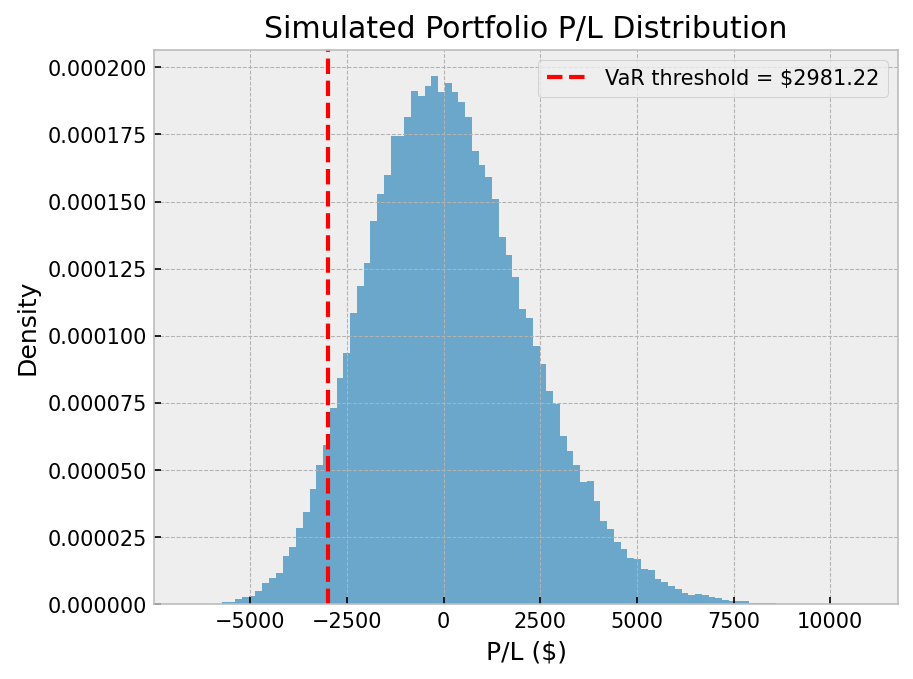

In [36]:
plt.hist(result['pnl'], bins=100, density=True, alpha=0.7)
plt.axvline(-result['VaR_abs'], color='r', linestyle='--', label=f'VaR threshold = ${result['VaR_abs']:.2f}')
plt.title('Simulated Portfolio P/L Distribution')
plt.xlabel('P/L ($)')
plt.ylabel('Density')
plt.legend()
plt.show()

#### Step 8: Conclusions

Key Takeaways:
* GARCH models provide a more realistic volatility estimate than historical σ.
* Black-Scholes allows pricing and hedging of European options; Greeks quantify risk exposures.
* Portfolio VaR estimates demonstrate the impact of derivatives on risk.
* Monte Carlo simulation captures nonlinear portfolio effects that parametric VaR may miss.

Overall:
This project demonstrates the ability to go from market data → quantitative modeling → derivatives pricing → risk measurement — the core workflow of a financial analyst or quant.

#### Step 9: Future Work & Extensions

1.	Multi-Asset Portfolio:
    * Include correlated stocks to model portfolio diversification effects
2.	Delta-Hedging Simulation:
    * Track P&L while rebalancing to maintain delta-neutral portfolio
3.	Expected Shortfall (CVaR):
    * Complement VaR with average loss beyond the threshold (done in this version of the notebook)
4.	Alternative Pricing Models:
    * Binomial trees for American options, or Monte Carlo for exotic options
5. Implied Volatility Analysis:
	* Compare Black-Scholes implied vol with market option prices
	* Visualize volatility smile or surface


✅ What we've achieved:
1.	Simulated thousands of possible future stock prices.
2.	Repriced the option for each scenario.
3.	Calculated the portfolio change distribution.
4.	Computed Monte Carlo 1-day VaR.
5.	Visualized portfolio risk with a histogram.

This completes a full workflow from option pricing to risk management.